In [1]:
import numpy as np 
import scipy as sp  
import random     
import bokeh 
import csv
import pandas as pd 
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [3]:
dataset = pd.read_csv("intersections-dataset.csv").values
print('dataset shape', dataset.shape)

### Notes:
 each 25 timestpes is 1 second
 
 distance to exit
 
 object id is car identifier
 
 will use relative x,y to polyfit(2 deg) with timestep 


In [6]:
for i,name in enumerate(dataset.columns):
    print(i, name)

0 Unnamed: 0
1 index
2 file_index
3 ObjectId
4 Flags
5 trackedByStationaryModel
6 mobile
7 motionModelValidated
8 ObjectAge
9 Timestamp
10 ObjectPredAge
11 Classification
12 ClassCertainty
13 ClassAge
14 ObjBoxCenter_X
15 ObjBoxCenter_Y
16 ObjBoxCenterSigma_X
17 ObjBoxCenterSigma_Y
18 ObjBoxSize_X
19 ObjBoxSize_Y
20 ObjCourseAngle
21 ObjCourseAngleSigma
22 ObjBoxOrientation
23 ObjBoxOrientationSigma
24 RelVelocity_X
25 RelVelocity_Y
26 RelVelocitySigma_X
27 RelVelocitySigma_Y
28 AbsVelocity_X
29 AbsVelocity_Y
30 AbsVelocitySigma_X
31 AbsVelocitySigma_Y
32 RefPointLocation
33 RefPointCoords_X
34 RefPointCoords_Y
35 RefPointCoordsSigma_X
36 RefPointCoordsSigma_Y
37 RefPointPosCorrCoeffs
38 ObjPriority
39 ObjExtMeasurement
40 EgoLatitude
41 EgoLongitude
42 EgoAltitude
43 EgoHeadingRad
44 EgoPosTimestamp
45 GPSFixStatus
46 csv_name
47 ObjPrediction
48 Object_X
49 Object_Y
50 uniqueId
51 origin
52 destination
53 relative_destination
54 AbsVelocity
55 distance
56 distance_to_exit
57 relative

In [3]:
#hyperparameters
step_size = 25  # 25 equal to one second, 15: 0.6sec, 1 : 0.04sec
remaining_time = 2. # at end of interval if distance to exit is less then Exit=True (THE LOWER THE BETTER)
start_dist = -1.  # distance from intersect to start recording
end_dist = 1.
FileName = 'preprocessed_data/Data_'+str(step_size)+'_'+str(remaining_time)+'_'+str(start_dist)+'_'+str(end_dist)+'.csv'

In [ ]:
# finds trajectory start and end points
start_index_list = []
end_index_list = []
skip_list = []  # to remove a specific intersection
start_bool = False
end_bool = False
for i, row in enumerate(dataset):
    if row[0] == 0:
        if start_bool:
            end_index_list.pop()
        if end_bool:
            start_index_list.pop()
        start_bool = True
        end_bool = True

    if start_bool and row[55] >= start_dist:
        skip_list.append(True if 'leith-croydon' in row[46] or row[11] != 5 else False)  # to remove map b and skip if not car
        start_index_list.append(i)
        start_bool = False
    if end_bool and row[56] >= end_dist:
        end_index_list.append(i)
        end_bool = False

print('len start_index', len(start_index_list))
print('len end_index', len(end_index_list))
if len(start_index_list) != len(end_index_list):
    print('Error')


pickle.dump( {'start':start_index_list, 'end':end_index_list, 'skip':skip_list},
            open( "start_{}_end_{}.p".format(start_dist, end_dist), "wb" ) )

In [ ]:
# load trajectory start and end points
start_end_index = pickle.load(open("start_{}_end_{}.p".format(start_dist, end_dist), 'rb'))
start_index_list = start_end_index['start']
end_index_list = start_end_index['end']
skip_list = start_end_index['skip']
print('trajectory count', len(start_index_list))

In [ ]:
# add header to csv file
# x-a x-b x-c y-a y-b y-c avg_vel, orgin:north, orgin:south, orgin:east, orgin:west
with open(FileName, 'w',newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['x_a', 'x_b', 'x_c', 'y_a', 'y_b', 'y_c', 
                     'avg_vel', 'orgin:north', 'orgin:south', 'orgin:east', 'orgin:west'])

with open(FileName[:-4]+'_y.csv', 'w',newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['ouput: 1:for exiting intersect'])


In [ ]:
counter = 0
Output_list = []
with open(FileName, 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for i, start_index in enumerate(start_index_list):
        
        print('progress', i/len(start_index_list))
        if skip_list[i]:  # or i+1 == len(index_list)
            continue
        end_index = end_index_list[i]
        
        if end_index-start_index < 50:  # skip short trajectory
            continue 
        steps = (end_index-start_index) // step_size
        start = end_index - steps * step_size
        print('vehicle:{}, steps{}'.format(i,steps))
        for s in range(steps):
            start = end_index - (s+1)*step_size
            end = end_index - s*step_size
            time_list = []
            x_list = []
            y_list = []
            AbsVelocity_sum = 0
            Exit = False
            directon = None

            for row in dataset[start:end]:
                time_list.append(row[9])
                x_list.append(row[57])
                y_list.append(row[58])
                AbsVelocity_sum += row[54]
            Exit = True if s >= (steps-remaining_time) else Exit  # checks if remiaing distance to exit is less than margin
            directon = row[51]
            if row[56] >= end_dist:
                break

            time_list =np.array(time_list)-min(time_list)
            x_a,x_b,x_c = np.polyfit(x=time_list,y=np.array(x_list),deg=2)
            y_a,y_b,y_c = np.polyfit(x=time_list,y=np.array(y_list),deg=2)
            avg_speed = AbsVelocity_sum/step_size

            if 'north' in directon:
                writer.writerow([x_a,x_b,x_c,y_a,y_b,y_c,avg_speed,1,0,0,0])
            elif 'south' in directon:
                writer.writerow([x_a,x_b,x_c,y_a,y_b,y_c,avg_speed,0,1,0,0])
            elif 'east' in directon:
                writer.writerow([x_a, x_b, x_c, y_a, y_b, y_c, avg_speed, 0, 0, 1, 0])
            else:  # west
                writer.writerow([x_a, x_b, x_c, y_a, y_b, y_c, avg_speed, 0, 0, 0, 1])
            Output_list.append(Exit)
            counter += 1
        with open(FileName[:-4] + '_y.csv', 'a', newline='') as csvfile2:
            writer1 = csv.writer(csvfile2)
            for Exit in Output_list:
                writer1.writerow([1] if Exit else [0])
            Output_list = []


vehicle:5187, steps3


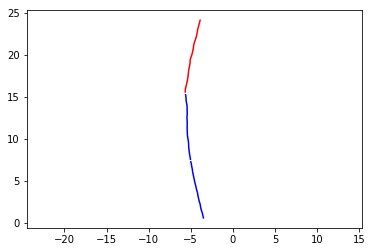

vehicle:5188, steps3


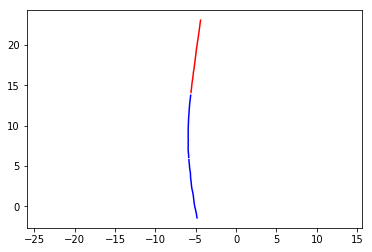

vehicle:5189, steps3


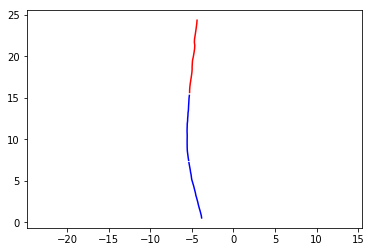

vehicle:5190, steps3


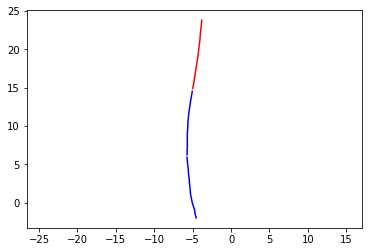

vehicle:5191, steps3


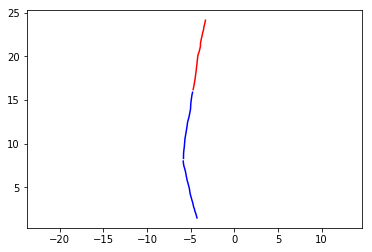

vehicle:5192, steps3


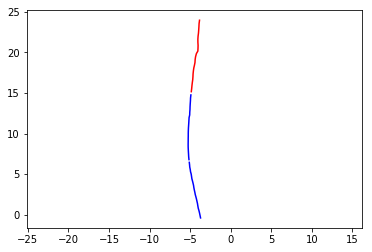

vehicle:5193, steps3


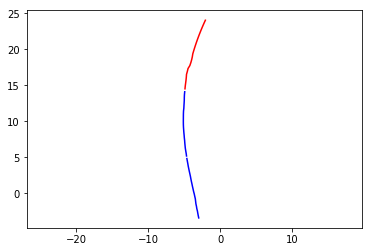

vehicle:5194, steps3


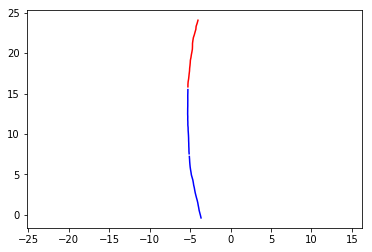

vehicle:5195, steps3


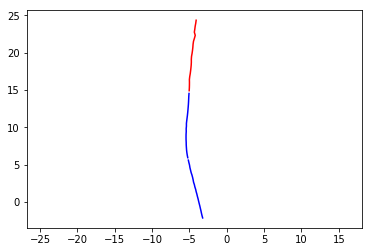

vehicle:5196, steps8


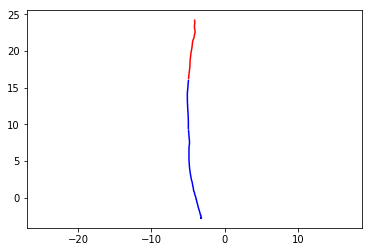

vehicle:5198, steps3


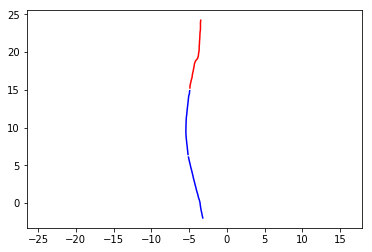

vehicle:5199, steps4


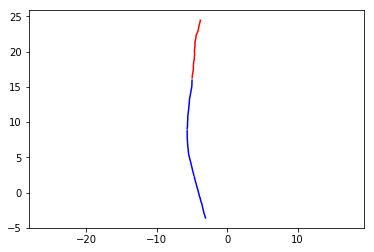

vehicle:5200, steps6


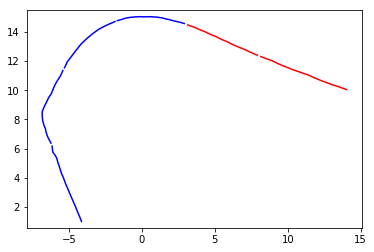

vehicle:5201, steps3


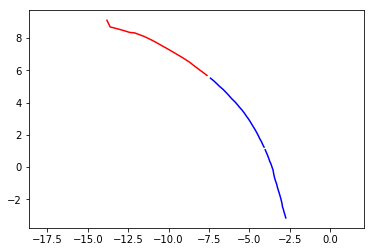

vehicle:5202, steps3


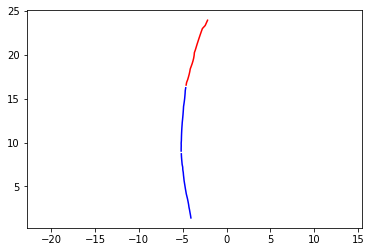

vehicle:5204, steps6


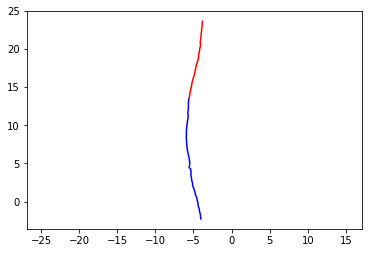

vehicle:5205, steps3


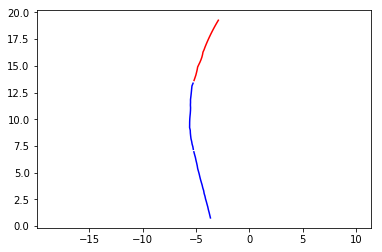

vehicle:5206, steps3


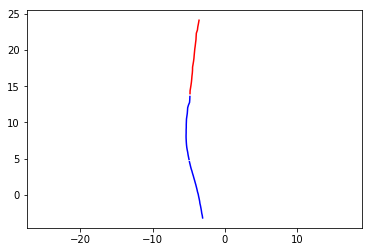

vehicle:5207, steps2


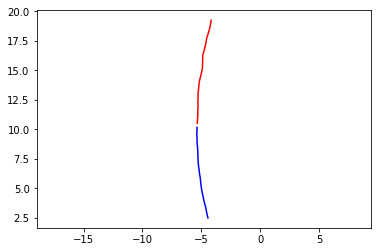

vehicle:5208, steps4


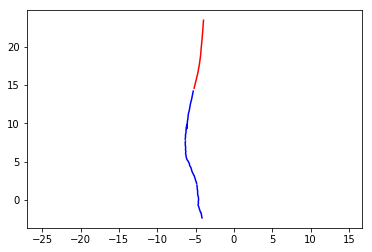

vehicle:5209, steps2


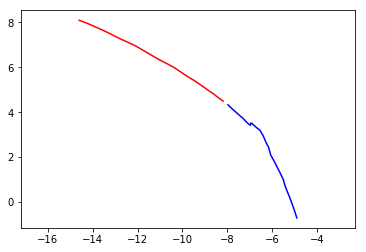

vehicle:5210, steps3


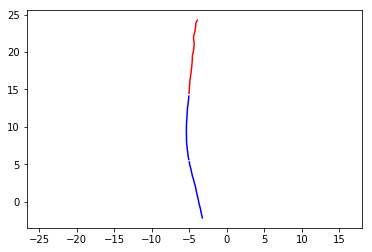

vehicle:5212, steps2


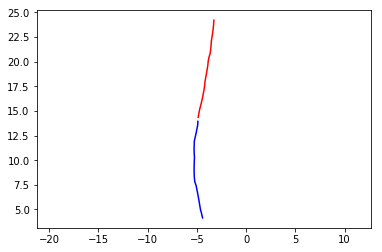

vehicle:5214, steps7


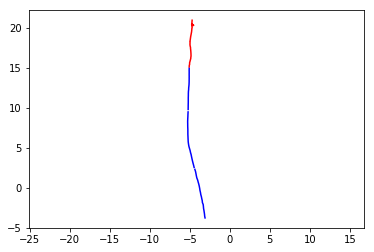

vehicle:5215, steps2


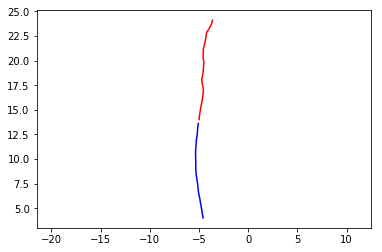

vehicle:5216, steps2


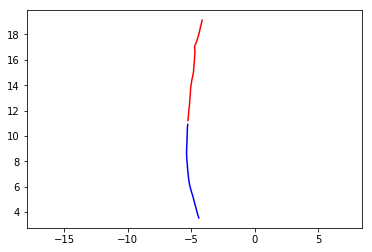

vehicle:5217, steps2


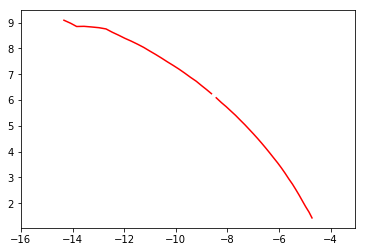

vehicle:5218, steps3


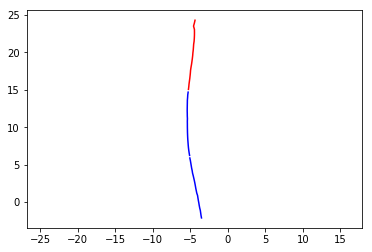

vehicle:5219, steps4


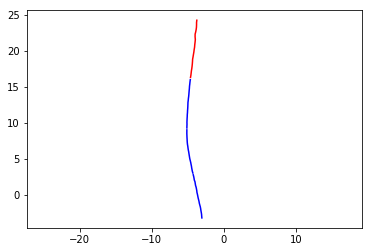

vehicle:5220, steps3


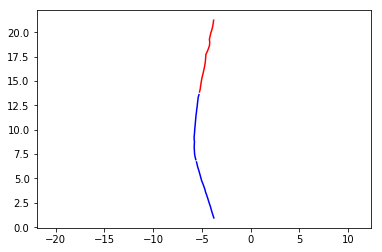

vehicle:5221, steps3


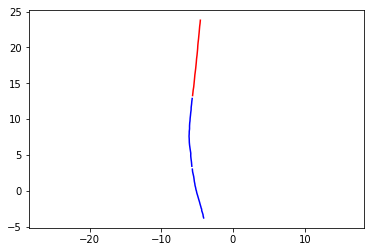

vehicle:5222, steps4


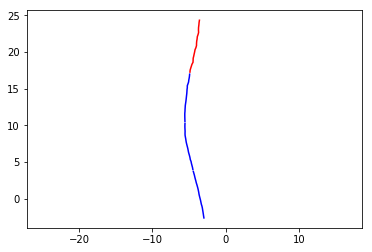

vehicle:5223, steps2


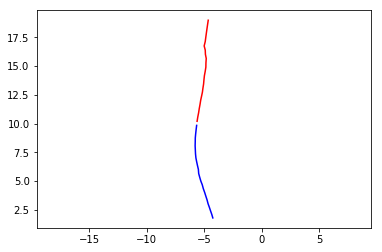

vehicle:5224, steps3


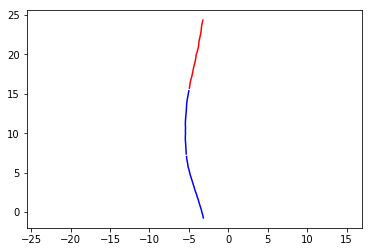

vehicle:5225, steps4


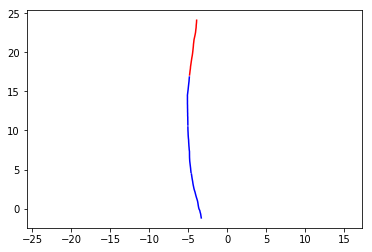

vehicle:5226, steps2


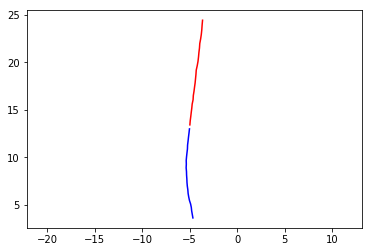

vehicle:5227, steps2


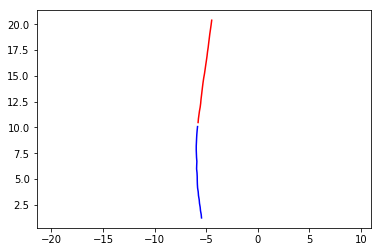

vehicle:5228, steps2


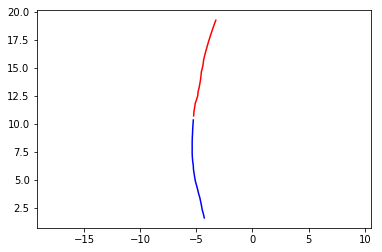

vehicle:5229, steps4


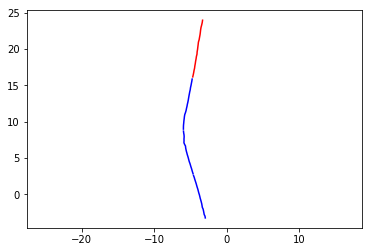

vehicle:5230, steps6


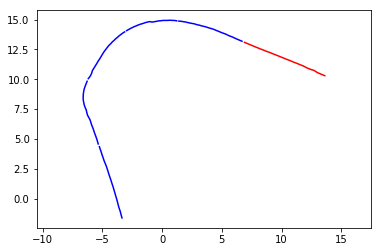

vehicle:5231, steps3


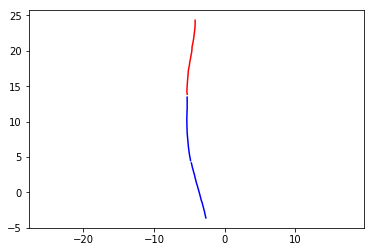

vehicle:5232, steps2


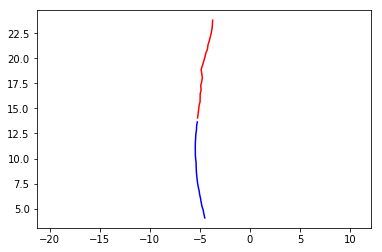

vehicle:5233, steps3


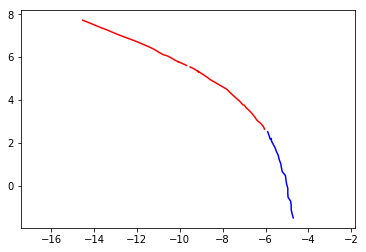

vehicle:5234, steps3


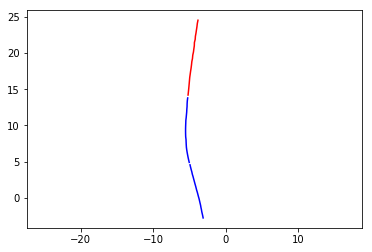

vehicle:5235, steps3


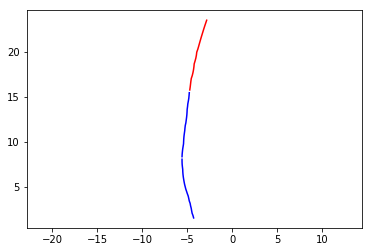

vehicle:5236, steps3


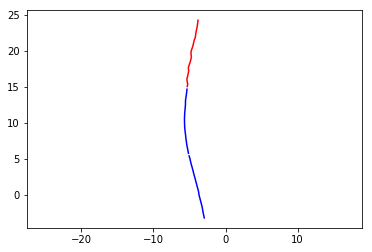

vehicle:5237, steps3


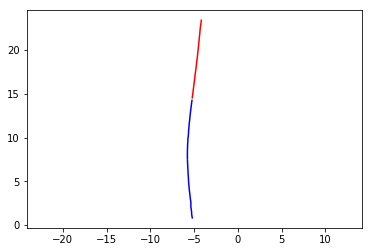

vehicle:5238, steps3


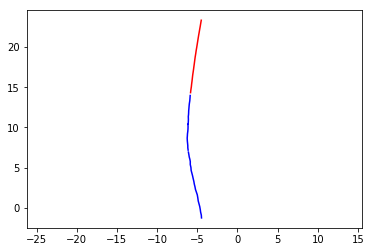

vehicle:5239, steps3


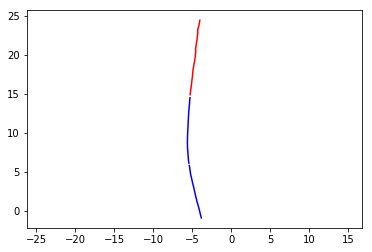

vehicle:5240, steps3


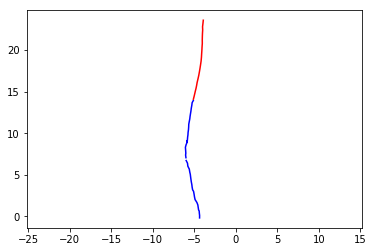

vehicle:5242, steps3


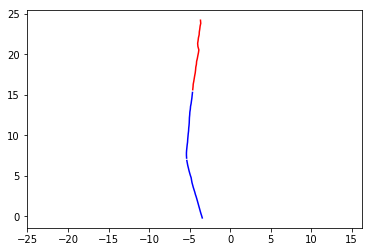

vehicle:5243, steps2


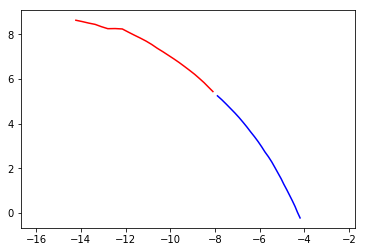

vehicle:5244, steps3


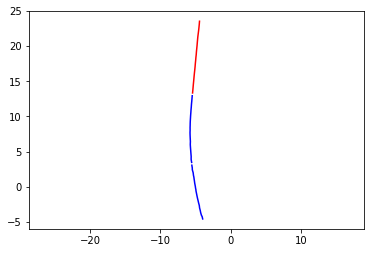

vehicle:5245, steps3


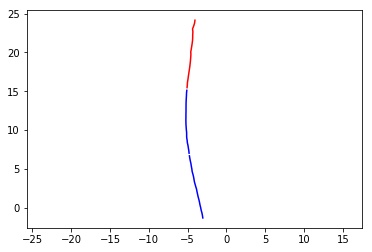

vehicle:5246, steps3


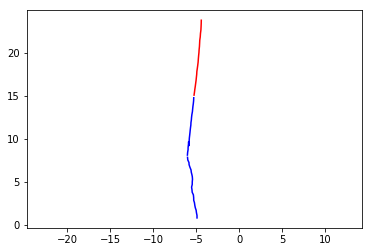

vehicle:5247, steps2


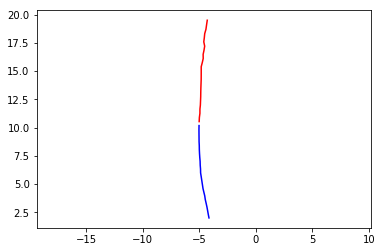

vehicle:5248, steps3


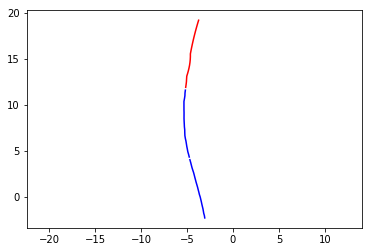

vehicle:5249, steps3


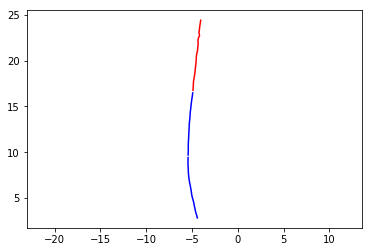

vehicle:5250, steps3


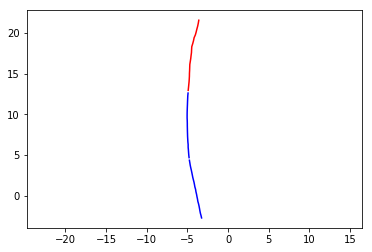

vehicle:5251, steps3


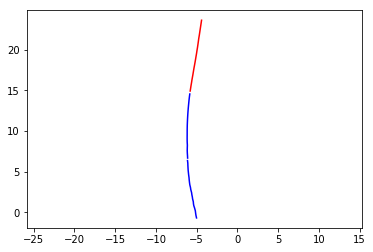

vehicle:5252, steps3


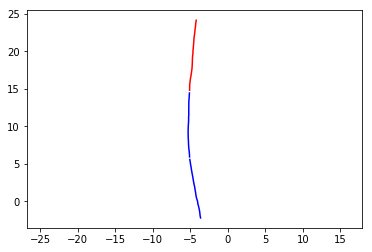

vehicle:5255, steps4


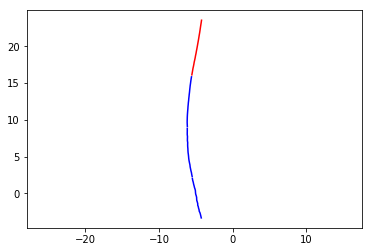

vehicle:5256, steps3


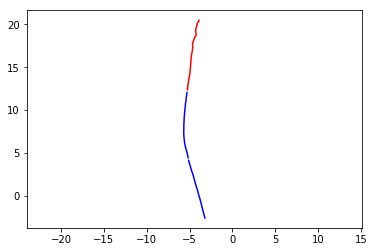

vehicle:5257, steps3


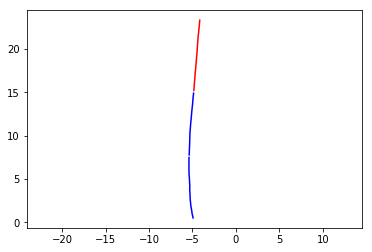

vehicle:5258, steps2


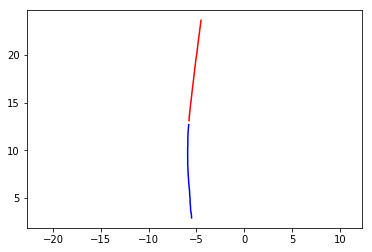

vehicle:5259, steps2


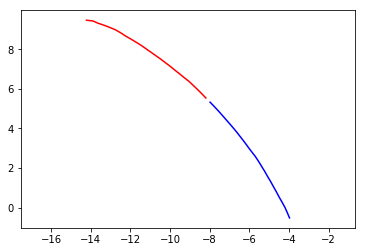

vehicle:5260, steps3


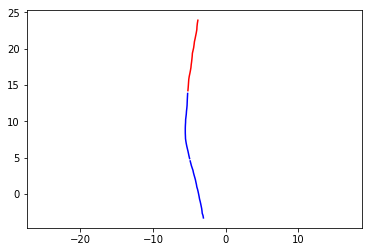

vehicle:5261, steps2


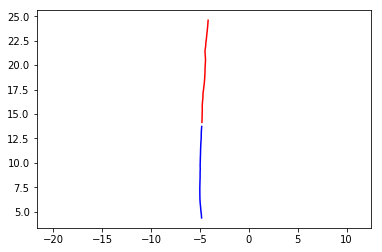

vehicle:5262, steps2


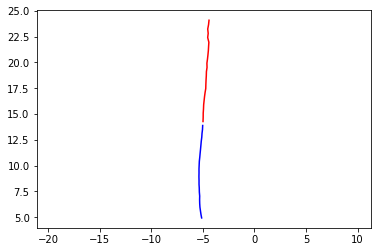

vehicle:5263, steps4


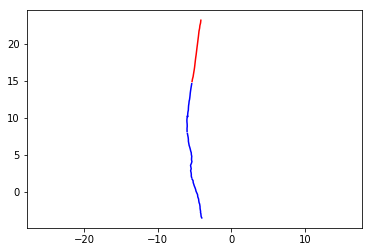

vehicle:5264, steps3


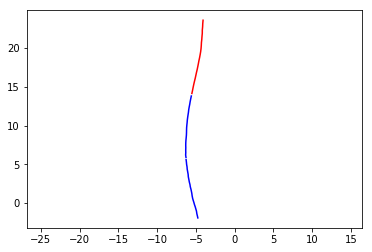

vehicle:5265, steps5


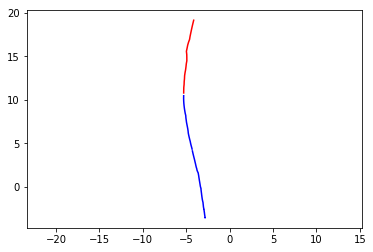

vehicle:5266, steps5


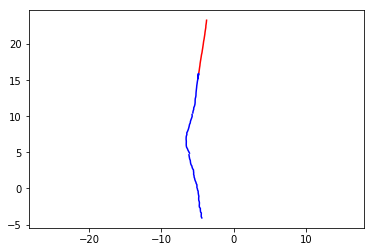

vehicle:5267, steps6


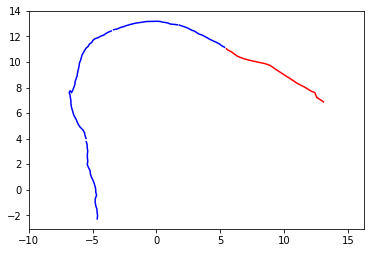

vehicle:5268, steps3


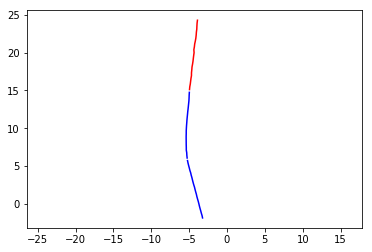

vehicle:5269, steps3


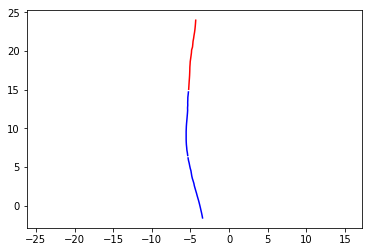

vehicle:5270, steps6


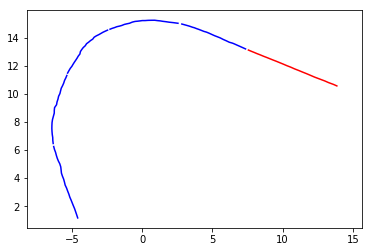

vehicle:5271, steps3


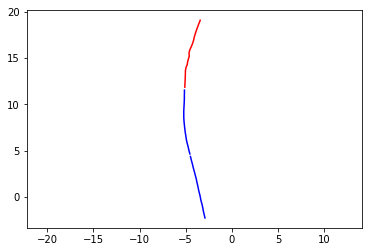

vehicle:5272, steps3


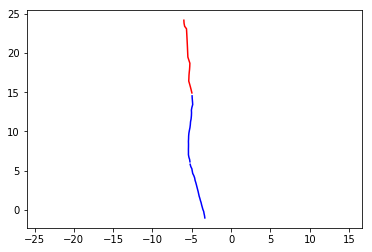

vehicle:5273, steps3


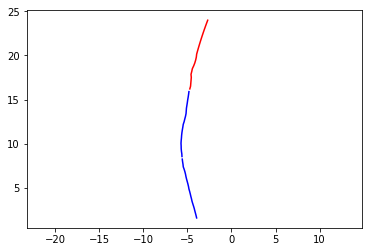

vehicle:5274, steps3


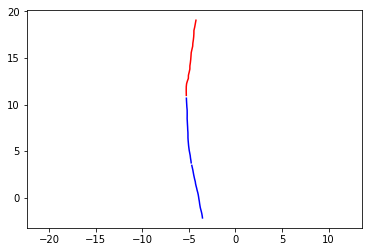

vehicle:5275, steps3


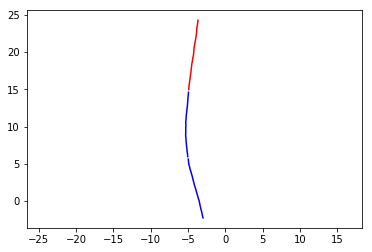

vehicle:5277, steps3


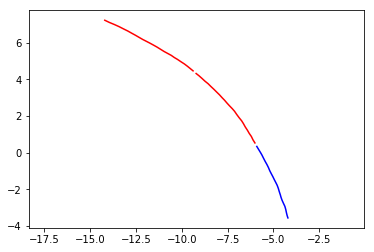

vehicle:5278, steps4


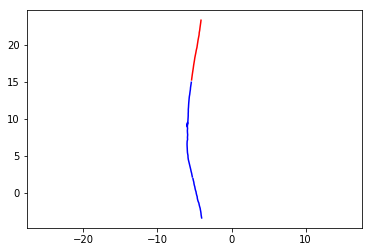

vehicle:5279, steps3


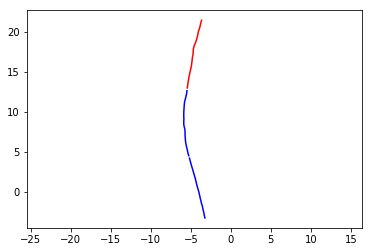

vehicle:5280, steps2


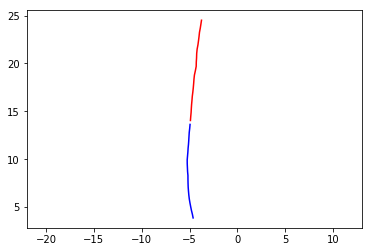

vehicle:5281, steps3


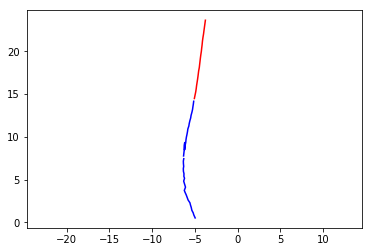

vehicle:5282, steps3


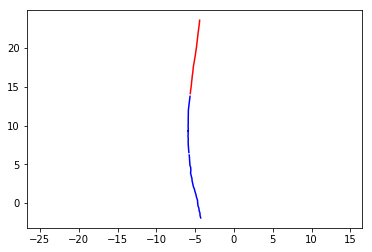

vehicle:5283, steps2


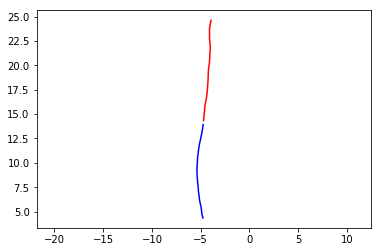

vehicle:5284, steps3


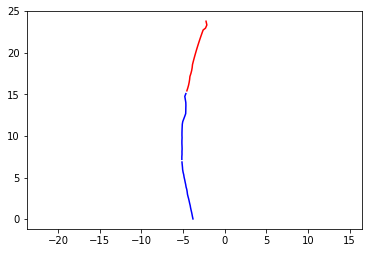

vehicle:5285, steps6


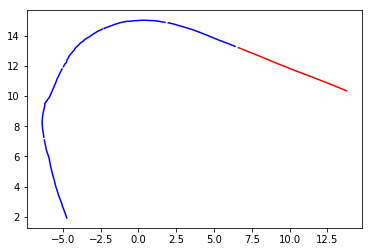

vehicle:5286, steps3


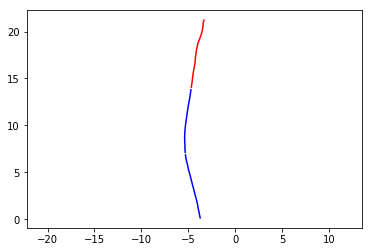

vehicle:5287, steps4


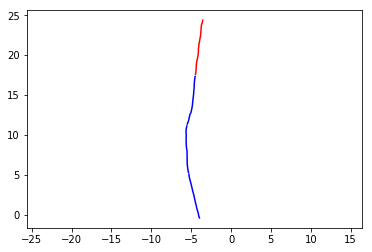

vehicle:5288, steps2


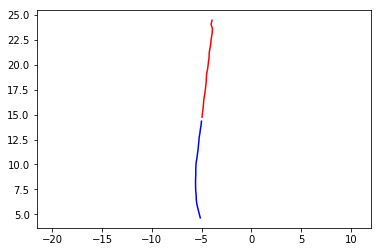

vehicle:5289, steps3


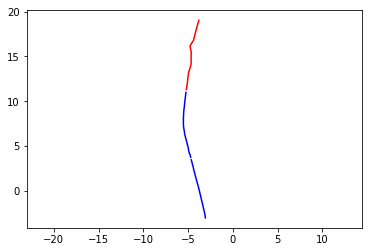

vehicle:5290, steps3


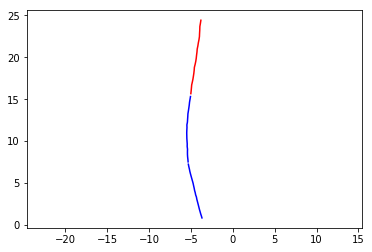

vehicle:5291, steps4


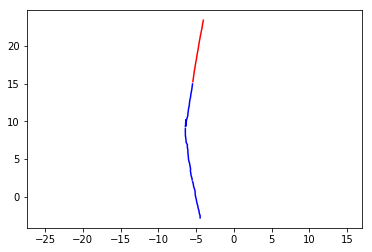

vehicle:5292, steps3


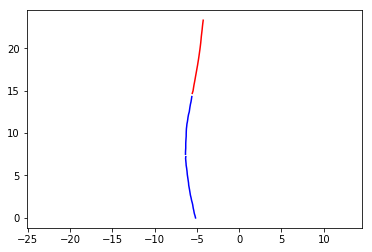

vehicle:5293, steps3


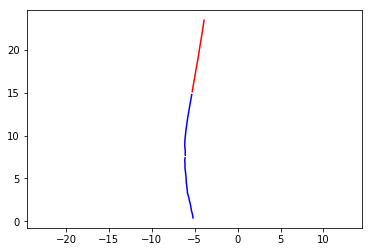

vehicle:5294, steps3


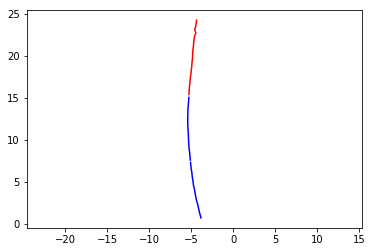

vehicle:5295, steps3


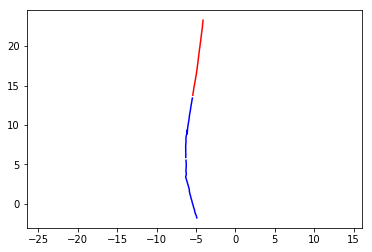

vehicle:5296, steps2


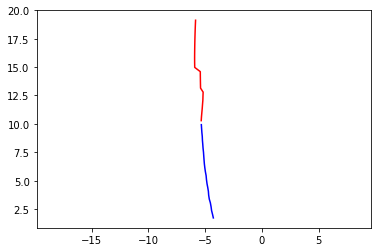

vehicle:5297, steps3


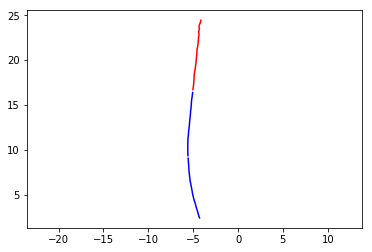

vehicle:5298, steps3


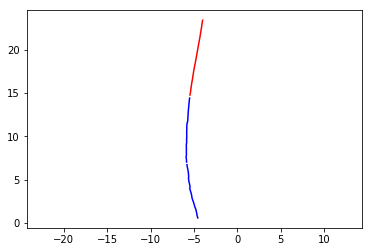

vehicle:5299, steps3


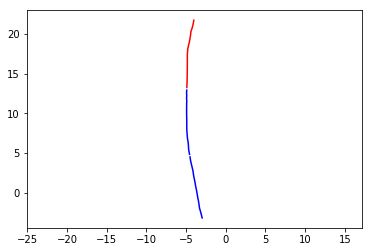

vehicle:5301, steps3


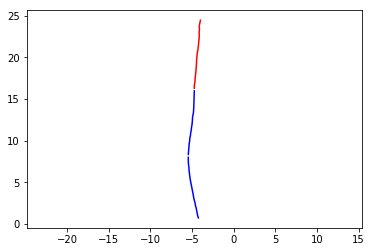

vehicle:5302, steps3


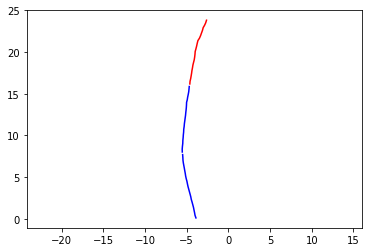

vehicle:5303, steps2


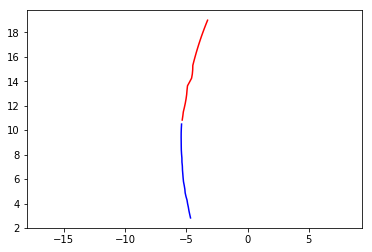

vehicle:5304, steps5


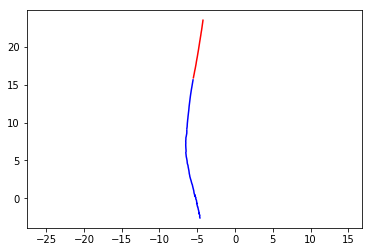

vehicle:5305, steps2


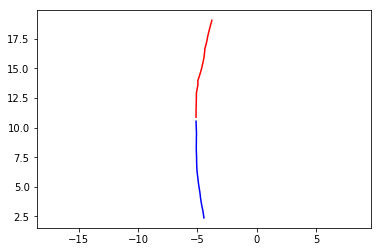

vehicle:5306, steps3


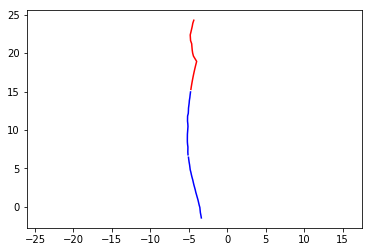

vehicle:5307, steps3


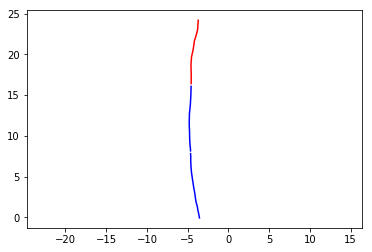

vehicle:5308, steps4


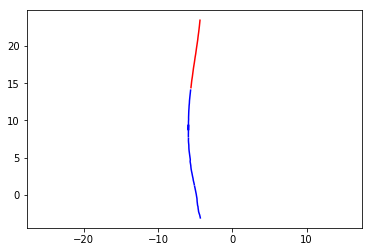

vehicle:5309, steps3


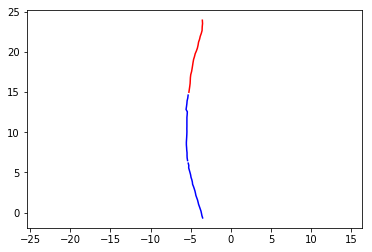

vehicle:5310, steps3


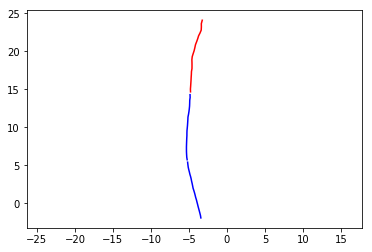

vehicle:5311, steps3


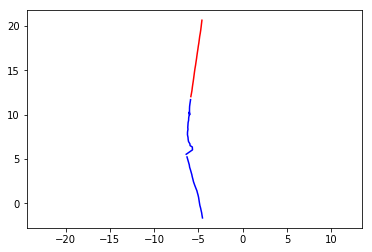

vehicle:5312, steps3


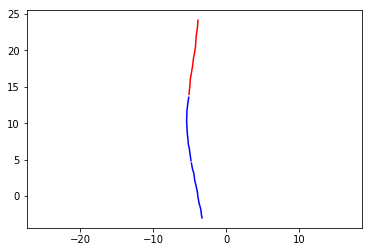

vehicle:5313, steps3


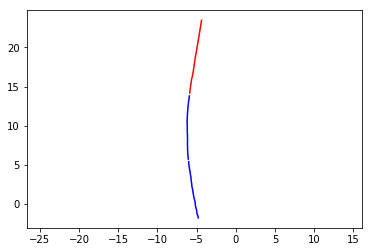

vehicle:5314, steps3


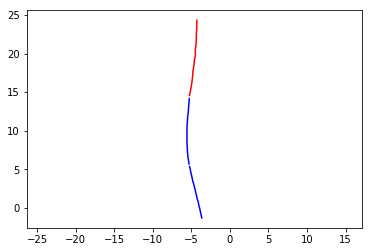

vehicle:5316, steps4


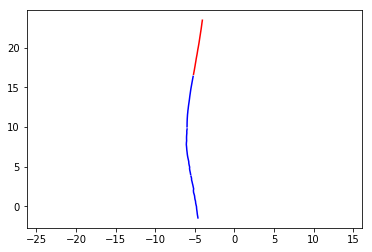

vehicle:5317, steps2


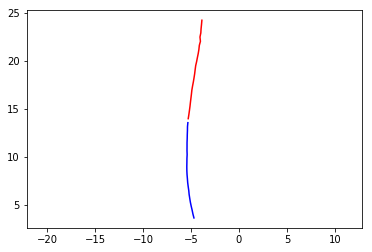

vehicle:5318, steps4


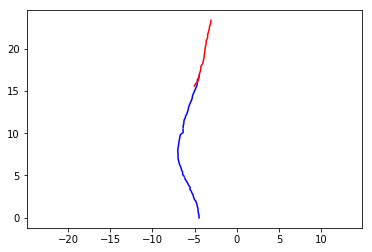

vehicle:5319, steps3


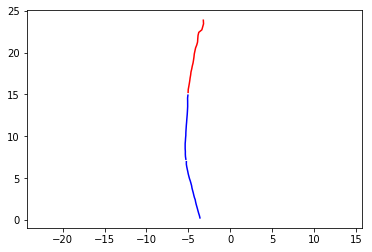

vehicle:5320, steps5


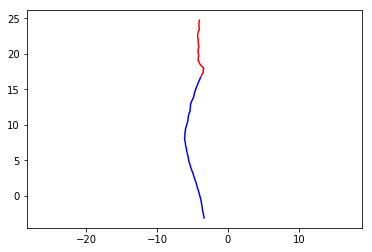

vehicle:5321, steps3


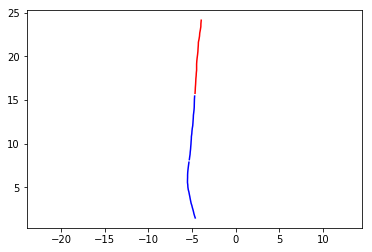

vehicle:5322, steps4


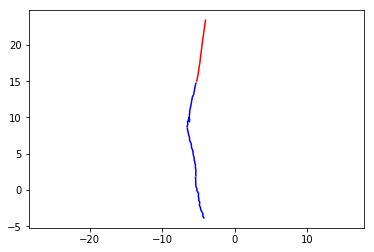

vehicle:5323, steps3


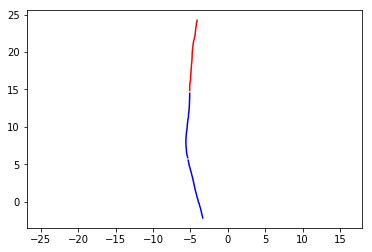

vehicle:5324, steps3


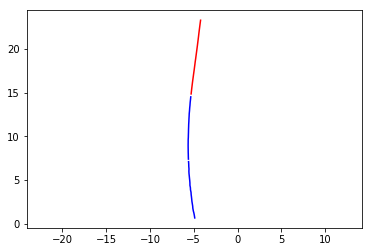

vehicle:5325, steps3


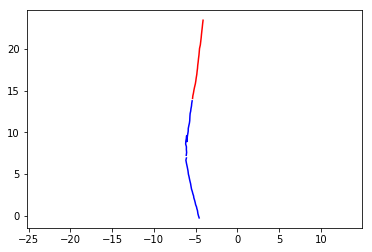

vehicle:5326, steps4


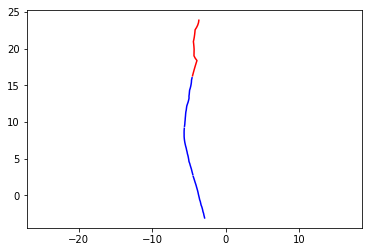

vehicle:5327, steps3


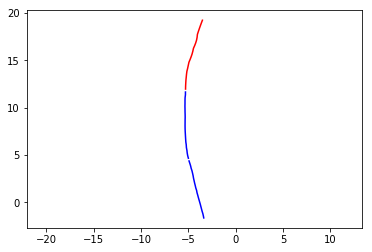

vehicle:5328, steps3


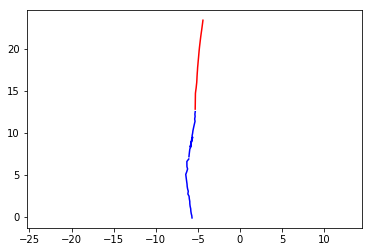

vehicle:5329, steps3


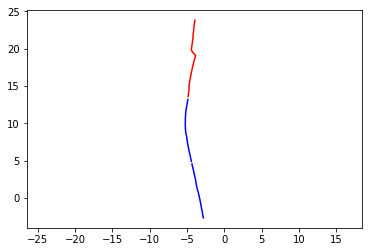

vehicle:5330, steps3


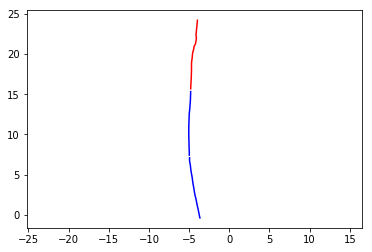

vehicle:5331, steps3


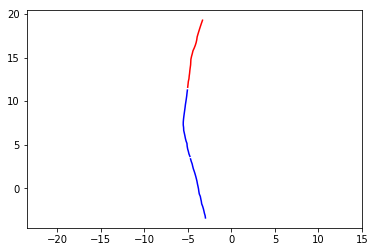

vehicle:5332, steps3


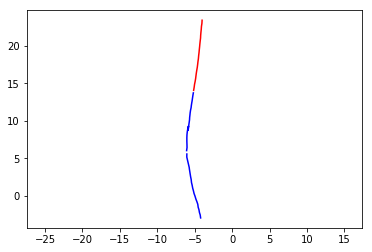

vehicle:5333, steps4


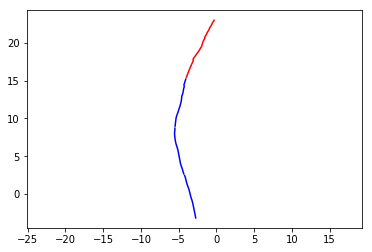

vehicle:5334, steps3


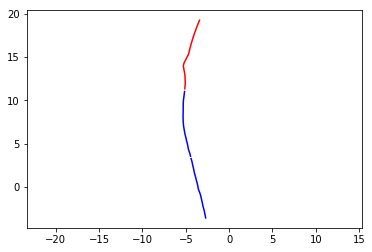

vehicle:5335, steps4


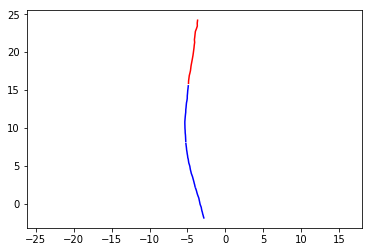

vehicle:5336, steps3


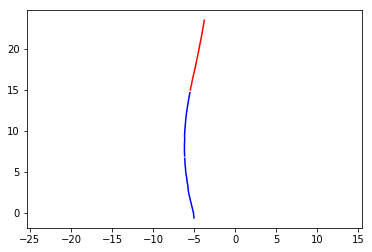

vehicle:5337, steps3


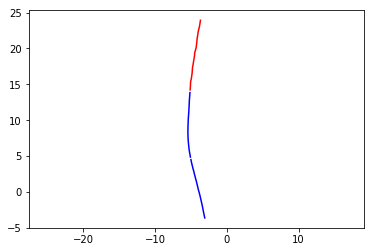

vehicle:5338, steps4


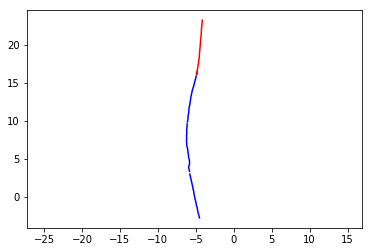

vehicle:5339, steps3


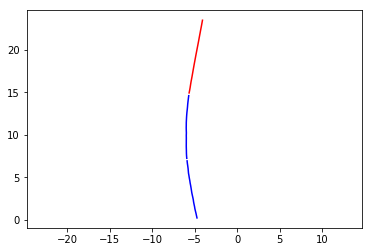

vehicle:5341, steps3


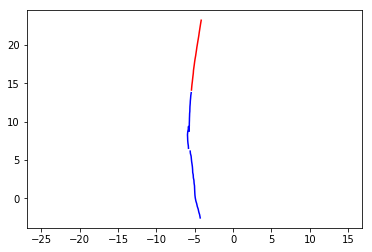

vehicle:5342, steps3


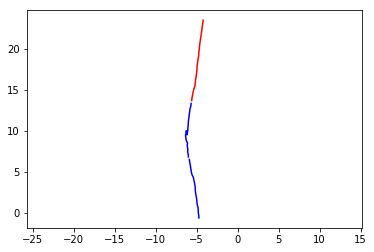

vehicle:5344, steps3


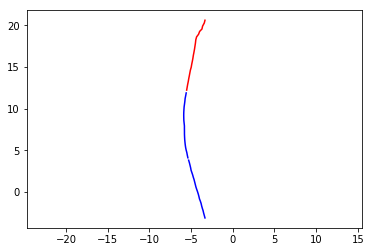

vehicle:5345, steps3


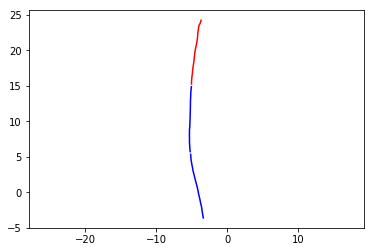

vehicle:5346, steps3


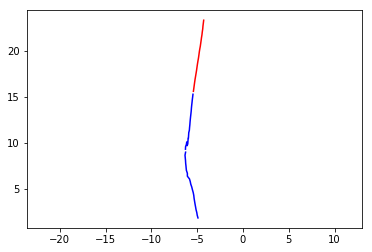

vehicle:5347, steps3


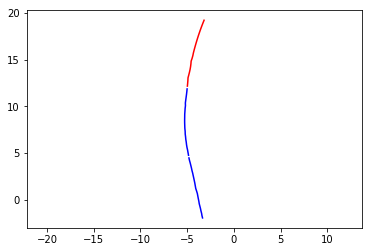

vehicle:5349, steps2


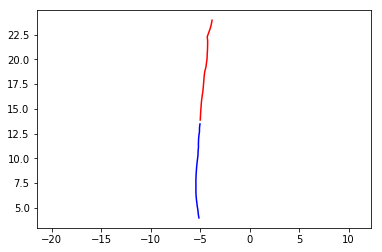

In [3]:
step_size = 25  # equal to one second
remaining_dist = -2. # at end of interval if distance to exit is less then Exit=True
start_dist = -2.  # distance from intersect to start recording
end_dist = 6.

start_end_index = pickle.load(open("start_end_index.p", 'rb'))
start_index_list = start_end_index['start']
end_index_list = start_end_index['end']
skip_list = start_end_index['skip']



counter = 0
for i, start_index in enumerate(start_index_list):
    if counter>=150:
        break
    #print('progress', i/len(start_index_list))
    if skip_list[i]:
        continue
    end_index = end_index_list[i]
    # skip short trajectory
    if end_index-start_index < 50:
        continue 
    steps = (end_index-start_index) // step_size
    start = end_index - steps * step_size
    print('vehicle:{}, steps{}'.format(i,steps))
    for count, chunk in enumerate(pd.read_csv("intersections-dataset.csv", skiprows=start, chunksize=step_size)):
        if count == steps:
            break
        time_list = []
        x_list = []
        y_list = []
        AbsVelocity_sum = 0
        Exit = False
        directon = None

        for row in chunk.values:
            time_list.append(row[9])
            x_list.append(row[57])
            y_list.append(row[58])
            AbsVelocity_sum += row[54]
        Exit = True if row[56] >= remaining_dist else Exit
        color='r' if Exit else 'b'
        plt.plot(x_list, y_list, color)
    plt.axis('equal')
    plt.show()
    counter += 1
    